In [ ]:
# default_exp hw4

# Import

In [ ]:
# export
import time
import warnings
import numpy as np
import matplotlib.pyplot as plt

import librosa
import librosa.display

from cs371.utils import *

# HW4

In [ ]:
def load_rankings(filename="data/rankings.txt"):
    """
    Load all student rankings from a file

    Parameters
    ----------
    filename: string
        Path to a file
    
    Returns
    -------
    superheros: A list of superheros in alphabetical order
    raters: dictionary( 
        string (Ranker's name): list (This person's ranking as a list of numbers
                                      corresponding to the indices in superheros)
    )
    """
    superhero_to_num = {}
    raters = {}
    superheros = []
    fin = open(filename)
    lines = [L.rstrip() for L in fin.readlines()]
    fin.close()
    i = 0
    N = 9
    while (i+1)*N <= len(lines):
        rater = lines[i*N]
        rankings = lines[i*N+1:(i+1)*N]
        if len(superhero_to_num) == 0:
            superheros = sorted(rankings)
            for k, name in enumerate(superheros):
                superhero_to_num[name] = k
        raters[rater] = [superhero_to_num[superhero] for superhero in rankings]
        i += 1
    return superheros, raters

In [ ]:
def plot_mds_distances(raters, random_state=0):
    """
    Compute all pairwise Kendall-Tau distances and plot a dimension 
    reduction from the Kendall-Tau metric space to 2D to visualize how
    similar different raters are

    Parameters
    ----------
    raters: dictionary( 
        string (Ranker's name): list (This person's ranking as a list of numbers
                                      corresponding to the indices in superheros)
    random_state: int
        A seed to determine which random isometry to use for MDS
    """
    from sklearn.manifold import MDS
    N = len(raters)
    D = np.zeros((N, N))
    rlist = [r for r in raters]
    for i, rater1 in enumerate(rlist):
        for j in range(i+1, N):
            rater2 = rlist[j]
            D[i, j] = kendall_tau(raters[rater1], raters[rater2])
    D = D+D.T
    embedding = MDS(n_components=2, dissimilarity='precomputed', random_state=random_state)
    X = embedding.fit_transform(D)
    plt.scatter(X[:, 0], X[:, 1])
    for i, r in enumerate(rlist):
        plt.text(X[i, 0], X[i, 1], r)
    plt.title("MDS Projected Kendall-Tau Distances")

Try naive approach

In [ ]:
r1 = np.array([0, 4, 3, 1, 2])
r2 = np.array([1, 4, 2, 3, 0])

In [ ]:
N = len(r1)

In [ ]:
def kendall_tau_naive(r1, r2):
    # Get every possible pair
    pairs1, pairs2 = set(), set()
    for idx1 in range(N):
        for idx2 in range(idx1+1, N):
            pairs1.add((r1[idx1], r1[idx2]))
            pairs2.add((r2[idx1], r2[idx2]))
    # Subtract same pairs from total # of pairs
    return (N*(N-1)//2 - len(pairs1.intersection(pairs2)))

In [ ]:
kendall_tau_naive(r1, r2)

7

Try sorting and counting number of inversions

In [ ]:
def kendall_tau_naive2(r1, r2):
    idx_sort = np.argsort(r1)
    r2_inv = idx_sort[r2]
    dist = 0
    for idx1 in range(N):
        for idx2 in range(idx1+1, N):
            if r2_inv[idx1] > r2_inv[idx2]:
                dist += 1
    return dist

In [ ]:
kendall_tau_naive2(r1, r2)

7

Try with merge sort. I think we only count inversions when `i2` is incremented?

In [ ]:
def _merge(x1, x2):
    x = np.empty(len(x1) + len(x2)) # This should be preallocated and passed thru
    i1, i2, num_inversions = 0, 0, 0
    while i1 < len(x1) or i2 < len(x2):
        if   i1 == len(x1):    # x1 is over
            x[i1+i2] = x2[i2]
            i2 += 1
        elif i2 == len(x2):    # x2 is over
            x[i1+i2] = x1[i1]
            i1 += 1
        else:                  # Both have elements left
            if x1[i1] < x2[i2]:
                x[i1+i2] = x1[i1]
                i1 += 1
            else:
                x[i1+i2] = x2[i2]
                i2 += 1
                num_inversions += len(x1) - i1
    return x, num_inversions

Merging `[1, 3]` and `[0, 2, 4]` should have 3 inversions

In [ ]:
_merge([1, 3], [0, 2, 4])

(array([0., 1., 2., 3., 4.]), 3)

In [ ]:
def mergesort(x):
    if len(x) < 2: return x, 0
    else:
        i_middle = len(x)//2
        x1, num_inversions1 = mergesort(x[:i_middle])
        x2, num_inversions2 = mergesort(x[i_middle:])
        x,  num_inversions3 = _merge(x1, x2)
        return x, num_inversions1 + num_inversions2 + num_inversions3

In [ ]:
def kendall_tau_mergesort(r1, r2):
    idx_sort = np.argsort(r1)
    r2_inv = idx_sort[r2]
    _, num_inversions = mergesort(r2_inv)
    return num_inversions

In [ ]:
kendall_tau_mergesort(r1, r2)

7

In [ ]:
N = 20
r1 = np.random.choice(N, N, replace=False)
r2 = np.random.choice(N, N, replace=False)
r1, r2

(array([ 7, 10, 12, 18,  8,  1,  5,  4,  0, 14, 17, 16,  9,  2, 13, 19, 15,
        11,  3,  6]),
 array([18,  0, 14, 13,  3,  2,  7,  6, 19, 16, 17,  8, 15, 10,  5,  1, 12,
         9, 11,  4]))

In [ ]:
kendall_tau_naive(r1, r2)

99

In [ ]:
kendall_tau_naive2(r1, r2)

99

In [ ]:
kendall_tau_mergesort(r1, r2)

99

In [ ]:
kendall_tau_naive(r1, r1), kendall_tau_naive2(r1, r1), kendall_tau_mergesort(r1, r1)

(0, 0, 0)

Looks ok

In [ ]:
def kendall_tau(r1, r2): return kendall_tau_mergesort(r1, r2)

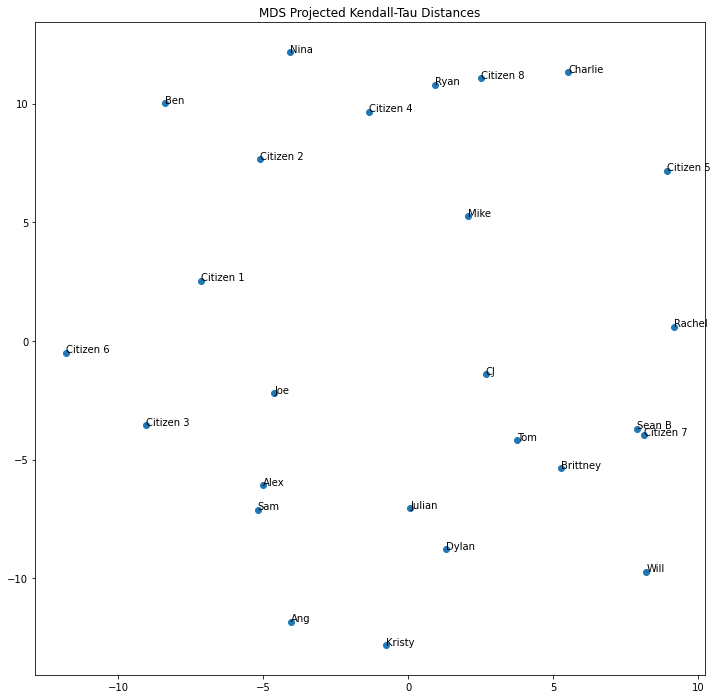

In [ ]:
plt.figure(figsize=(12, 12))
superheros, raters = load_rankings()
plot_mds_distances(raters, 1)
plt.show()

Diameter code

In [ ]:
def diameter(raters):
    N = len(raters)
    D = np.full((N, N), -np.inf)
    rlist = [r for r in raters]
    for i, rater1 in enumerate(rlist):
        for j in range(i+1, N):
            rater2 = rlist[j]
            D[i, j] = kendall_tau(raters[rater1], raters[rater2])
    rows, cols = np.where(D == D.max())
    diameters = []
    for i, j in zip(rows, cols):
        diameters.append((rlist[i],rlist[j],D[i,j]))
    return diameters

In [ ]:
diameter(raters)

[('Ang', 'Citizen 8', 28.0)]

Average Rank Aggregation

In [ ]:
superheros = np.array([
    'Captain America',
    'Deadpool',
    'Dr. Doofenshmirtz',
    'Megamind',
    'Spiderman',
    'The Flash',
    'The Joker',
    'Thor'
])

In [ ]:
def average_rank_aggregation(raters, superheros):
    scores = np.zeros(len(superheros))
    values = np.arange(len(superheros))[::-1]
    for rank in raters.values():
        scores[rank] += values
    scores /= len(raters)
    idx_sort = np.argsort(scores)[::-1]
    return idx_sort

In [ ]:
idx_sort = average_rank_aggregation(raters, superheros)

In [ ]:
idx_sort

array([4, 1, 6, 0, 7, 2, 3, 5])

In [ ]:
for idx, superhero in enumerate(superheros[idx_sort]):
    print(f'{idx+1} : {superhero}')

1 : Spiderman
2 : Deadpool
3 : The Joker
4 : Captain America
5 : Thor
6 : Dr. Doofenshmirtz
7 : Megamind
8 : The Flash


Brute Force Kemeny Optimal Ranking

In [ ]:
def _swap(r, idx1, idx2): r[idx1], r[idx2] = r[idx2], r[idx1]

In [ ]:
def _perm(r, idx0=0, min_cost={}):
    if idx0 == len(r):
        cost = 0
        for r_rater in raters.values():
            cost += kendall_tau(r, r_rater)
        if not min_cost or min_cost['cost'] > cost:
            min_cost['cost'] = cost
            min_cost['r']    = r.copy()
            
    for idx in range(idx0, len(r)):
        _swap(r, idx0, idx)
        _perm(r, idx0+1, min_cost)
        _swap(r, idx0, idx)

In [ ]:
min_cost = {}
_perm(np.arange(8), min_cost=min_cost)

In [ ]:
min_cost

{'cost': 294, 'r': array([1, 4, 0, 6, 7, 5, 2, 3])}

In [ ]:
for idx, superhero in enumerate(superheros[min_cost['r']]):
    print(f'{idx+1} : {superhero}')

1 : Deadpool
2 : Spiderman
3 : Captain America
4 : The Joker
5 : Thor
6 : The Flash
7 : Dr. Doofenshmirtz
8 : Megamind


# Build

In [ ]:
build_notebook()

<IPython.core.display.Javascript object>

Converted hw4.ipynb.
